### Parse and convert protocol buffers

Inspired by
https://stackoverflow.com/questions/38958751/parsing-nyc-transit-mta-historical-gtfs-data-not-realtime
Data Source

This extracts data from the protobufs manually downloaded from [MTA Alert Archive](http://web.mta.info/developers/data/archives.html)the latest source suggested at:
https://groups.google.com/d/msg/mtadeveloperresources/Whm5XTVINcE/z-LO12ANAAAJ

Additional feeds are listed here:
http://web.mta.info/developers/developer-data-terms.html

Note that the above historical datasource is outdated, and the above MTA Alert Archive is correct

NOTE: This assumes that the protobufs have already been downloaded to <code>MTADelayPredict/data/raw/status</code> e.g. <code>MTADelayPredict/data/raw/status/201901.zip</code>

In [2]:
import os
data_dir = '../data/raw/status'

In [8]:
proto_file = os.path.join(os.path.join(data_dir), 'gtfs-realtime.proto')
#! wget -O $proto_file https://developers.google.com/transit/gtfs-realtime/gtfs-realtime.proto

In [9]:
proto_file = os.path.join(os.path.join(data_dir), 'gtfs-realtime.proto')
#! wget -O $proto_file https://developers.google.com/transit/gtfs-realtime/gtfs-realtime.proto

In [10]:
! protoc -I $data_dir --python_out=$data_dir $data_dir/nyct-subway.proto $data_dir/gtfs-realtime.proto

[libprotobuf WARNING google/protobuf/compiler/parser.cc:637] No syntax specified for the proto file: nyct-subway.proto. Please use 'syntax = "proto2";' or 'syntax = "proto3";' to specify a syntax version. (Defaulted to proto2 syntax.)


## Examine single delay case

Selected from [MTA Alert Archive](http://web.mta.info/developers/data/archives.html).  I also received an email alert for this, and it could have potentially impacted my commute if it had happened slightly earlier in the day.  We are going to begin this exercise focusing *exclusively* on northbound N trains.

![](files/20181221_0919_NR_Delay.png "20181221 Alert")

First, fetch the alert from the downloaded alert data.

### Load alert historical data

In [3]:
import pandas as pd
import os 

In [4]:
alert_dir = '../data/raw/alerts'
alert_df = pd.read_csv(os.path.abspath(os.path.join(alert_dir, 'raw_alerts_12.01.2018_12.31.2018.csv')))
alert_df.index = alert_df.Date.map(pd.to_datetime)
alert_df.drop(columns=['Date'], inplace=True)
alert_df.sort_index(inplace=True)

In [5]:
alert_df.loc[alert_df.Subject.str.match(r'.*N and R.*')]['2018-12-21 09:10':'2018-12-21 22:20']

,Agency,Subject,Message
Date,,,
2018-12-21 09:19:00,NYC,"BKLYN, N and R Trains, Delays",Northbound N and R trains are running with som...


#### No delay resolution message

This is an interesting example because we receive a delay message, however there is no subsequent resolution sent, as there are in some cases of actual stoppage e.g. "UPDATED: N and R Trains have resumed running with residual delays"

In [6]:
alert_df.loc[alert_df.Subject.str.match(r'UPDATE.*N and R.*')]['2018-12-21 09:10':'2018-12-21 22:20']

,Agency,Subject,Message
Date,,,


### Load subway gtfs statuses from this time period

Also download stop ID's to make this more easily explorable

In [7]:
#!wget -O $data_dir/Stations.csv http://web.mta.info/developers/data/nyct/subway/Stations.csv 
stations_df = pd.read_csv(data_dir + '/Stations.csv')
stations_df.index = stations_df['GTFS Stop ID']

In [8]:
# We are looking for station R16 aka Times Sq - 42 St
stations_df.loc['R16']

Station ID                                11
Complex ID                               611
GTFS Stop ID                             R16
Division                                 BMT
Line                     Broadway - Brighton
Stop Name                   Times Sq - 42 St
Borough                                    M
Daytime Routes                       N Q R W
Structure                             Subway
GTFS Latitude                        40.7547
GTFS Longitude                      -73.9868
North Direction Label        Uptown & Queens
South Direction Label    Downtown & Brooklyn
Name: R16, dtype: object

In [72]:
# Download some other stuff we need for processing data
!wget -O $data_dir/google_transit.zip http://web.mta.info/developers/data/nyct/subway/google_transit.zip
import zipfile
with zipfile.ZipFile(data_dir+'/google_transit.zip') as zf:
    zf.extractall(data_dir+'/google_transit')

--2020-04-29 16:31:11--  http://web.mta.info/developers/data/nyct/subway/google_transit.zip
Resolving web.mta.info (web.mta.info)... 23.54.160.42, 23.54.160.27
Connecting to web.mta.info (web.mta.info)|23.54.160.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘../data/raw/status/google_transit.zip’

../data/raw/status/     [   <=>              ]   4.45M  8.09MB/s    in 0.5s    

2020-04-29 16:31:11 (8.09 MB/s) - ‘../data/raw/status/google_transit.zip’ saved [4663679]



In [131]:
pd.read_csv(data_dir+'/google_transit/stops.txt')

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,101,NaN,Van Cortlandt Park - 242 St,NaN,40.889248,-73.898583,NaN,NaN,1,NaN
1,101N,NaN,Van Cortlandt Park - 242 St,NaN,40.889248,-73.898583,NaN,NaN,0,101
2,101S,NaN,Van Cortlandt Park - 242 St,NaN,40.889248,-73.898583,NaN,NaN,0,101
3,103,NaN,238 St,NaN,40.884667,-73.900870,NaN,NaN,1,NaN
4,103N,NaN,238 St,NaN,40.884667,-73.900870,NaN,NaN,0,103
...,...,...,...,...,...,...,...,...,...,...
1498,S30N,NaN,Tompkinsville,NaN,40.636949,-74.074835,NaN,NaN,0,S30
1499,S30S,NaN,Tompkinsville,NaN,40.636949,-74.074835,NaN,NaN,0,S30
1500,S31,NaN,St George,NaN,40.643748,-74.073643,NaN,NaN,1,NaN
1501,S31N,NaN,St George,NaN,40.643748,-74.073643,NaN,NaN,0,S31


In [126]:
! ls $data_dir/google_transit

agency.txt    calendar_dates.txt  shapes.txt	  stops.txt	 trips.txt
calendar.txt  routes.txt	  stop_times.txt  transfers.txt


In [9]:
import sys
sys.path.append(os.path.join(data_dir))
import nyct_subway_pb2
import gtfs_realtime_pb2

In [10]:
msg = gtfs_realtime_pb2.FeedMessage()

with open(os.path.join(data_dir, '201812/20181221/gtfs_nqrw_20181221_091953.gtfs'),'rb') as fh:
#with open(os.path.join(data_dir, '201812/20181221/gtfs_bdfm_20181221_091949.gtfs'),'rb') as fh:
    msg.ParseFromString(fh.read())

In [11]:
def entity_generator(msg):
    for e in msg.entity:
        if e.HasField('vehicle'):
            yield e

In [12]:
gen = entity_generator(msg)

In [13]:
next(gen)

id: "16000002"
vehicle {
  trip {
    trip_id: "047796_N..N"
    start_date: "20181221"
    route_id: "N"
    [nyct_trip_descriptor] {
      train_id: "1N 0758 86S/DIT"
      is_assigned: true
      direction: NORTH
    }
  }
  current_stop_sequence: 28
  current_status: STOPPED_AT
  timestamp: 1545401983
}

In [14]:
msg

header {
  gtfs_realtime_version: "1.0"
  incrementality: FULL_DATASET
  timestamp: 1545401993
  [nyct_feed_header] {
    nyct_subway_version: "1.0"
    trip_replacement_period {
      route_id: "N"
      replacement_period {
        end: 1545403793
      }
    }
    trip_replacement_period {
      route_id: "W"
      replacement_period {
        end: 1545403793
      }
    }
    trip_replacement_period {
      route_id: "Q"
      replacement_period {
        end: 1545403768
      }
    }
    trip_replacement_period {
      route_id: "R"
      replacement_period {
        end: 1545403779
      }
    }
  }
}
entity {
  id: "16000001"
  trip_update {
    trip {
      trip_id: "047796_N..N"
      start_date: "20181221"
      route_id: "N"
      [nyct_trip_descriptor] {
        train_id: "1N 0758 86S/DIT"
        is_assigned: true
        direction: NORTH
      }
    }
    stop_time_update {
      arrival {
        time: 1545401983
      }
      departure {
        time: 1545401983
      }

In [109]:
msg.header.timestamp

1545401993

In [103]:
gtfs_realtime_pb2.VehiclePosition.VehicleStopStatus.STOPPED_AT

1

In [107]:
gtfs_realtime_pb2.VehiclePosition.VehicleStopStatus.keys()

['INCOMING_AT', 'STOPPED_AT', 'IN_TRANSIT_TO']

In [123]:
stopped_at_df

,28,24,22,26,11,15,17,13,19,12,...,42,37,36,33,32,27,29,18,5,3
2018-12-21 14:19:53+00:00,2018-12-21 14:19:28+00:00,2018-12-21 14:19:18+00:00,2018-12-21 14:19:28+00:00,2018-12-21 14:19:28+00:00,2018-12-21 14:14:48+00:00,2018-12-21 14:19:18+00:00,2018-12-21 14:19:23+00:00,2018-12-21 14:19:43+00:00,2018-12-21 14:19:18+00:00,2018-12-21 14:19:08+00:00,...,2018-12-21 14:19:23+00:00,2018-12-21 14:19:28+00:00,2018-12-21 14:19:31+00:00,2018-12-21 14:19:23+00:00,2018-12-21 14:19:28+00:00,2018-12-21 14:19:28+00:00,2018-12-21 14:19:28+00:00,2018-12-21 14:19:28+00:00,2018-12-21 14:19:28+00:00,2018-12-21 14:19:29+00:00


In [121]:
pd.to_datetime(msg.header.timestamp, unit='s')

Timestamp('2018-12-21 14:19:53')

In [52]:
def show_stops(stop_time_update, stop_id):
    for stop in stop_time_update:
        print(stop)

In [204]:
stop_iter = stop_times(msg,  nyct_subway_pb2.NyctTripDescriptor.Direction.NORTH, 'N', 'R16')

In [20]:
# Retrieved from: https://docs.python.org/3/library/itertools.html#itertools.groupby 4/29/2020
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [38]:
# There is a problem where the vehicle entites don't provide an easily discernable stop name
# However, tfhe entities are paired up in as trip_entity  and vehicle entity
# We can just iterate through the entities in groups of 2, and we always know what stop we are actually stopped at

# TODO: Examine cases where this isn't well broken up into trip_update/vehicle pairings, maybe there are some other fun messages there

def get_entities(msg):
    for trip_entity,vehicle_entity in grouper(msg.entity, 2):
        
        try:
            assert trip_entity.HasField('trip_update')
            assert vehicle_entity.HasField('vehicle')
            assert trip_entity.trip_update.trip.trip_id == vehicle_entity.vehicle.trip.trip_id
        except Exception:
            print("Skipping entity pairing".format())
            continue 
            
        yield((trip_entity, vehicle_entity))

In [120]:
# Iterate through all files for a day and stuff the stop times into a dataframe
import glob
import progressbar

stopped_at_df = pd.DataFrame()
next_scheduled_arrival_df = pd.DataFrame()
next_train_df = pd.DataFrame()

min_arrival_dict = dict()

direction = nyct_subway_pb2.NyctTripDescriptor.Direction.NORTH
SEARCH_ROUTE_ID = 'N'
SEARCH_STOP_ID = 'R16N'

yyyymmdd = '20181221'

gtfs_files = glob.glob(os.path.join(data_dir,yyyymmdd[:6], yyyymmdd, 'gtfs_nqrw_{}_*.gtfs'.format(yyyymmdd)))
widgets = [progressbar.Percentage(), progressbar.Bar(), progressbar.Variable('entries')]
bar = progressbar.ProgressBar(widgets=widgets, max_value=len(gtfs_files), min_poll_interval=.5).start()

for i,file in enumerate(gtfs_files):
    
    try:
        with open(os.path.join(file),'rb') as fh:
            msg.ParseFromString(fh.read())
    except Exception:
        continue
        
    bar.update(i+1, entries=stopped_at_df.shape[0])
    
    for trip_entity,vehicle_entity in get_entities(msg):
    #    trip_direction = vehicle_entity.vehicle.trip_update.trip.Extensions[nyct_subway_pb2.nyct_trip_descriptor].direction

        trip_direction = vehicle_entity.vehicle.trip.Extensions[nyct_subway_pb2.nyct_trip_descriptor].direction
        route_id = vehicle_entity.vehicle.trip.route_id

        if vehicle_entity.vehicle.current_status == gtfs_realtime_pb2.VehiclePosition.VehicleStopStatus.STOPPED_AT:
            # Current stop is always the first stop_update in the trip entity as per: http://datamine.mta.info/sites/all/files/pdfs/GTFS-Realtime-NYC-Subway%20version%201%20dated%207%20Sep.pdf
            # Therefore, if a train is "STOPPED_AT", we can get the current stop_id this way
            current_stop = trip_entity.trip_update.stop_time_update[0]
            # NOTE: Sometimes the arrival times for the current stop don't match up, this is a bit weird, look into this
            #    assert current_stop.arrival.time <= vehicle_entity.vehicle.timestamp
            stop_id = current_stop.stop_id
            
            if stop_id == SEARCH_STOP_ID:
                #stopped_at_df.loc[pd.to_datetime(msg.header.timestamp, unit='s'), stop_id] = pd.to_datetime(vehicle_entity.vehicle.timestamp, unit='s')
                stopped_at_df.loc[pd.to_datetime(msg.header.timestamp, unit='s', utc=True), stop_id] = vehicle_entity.vehicle.trip.Extensions[nyct_subway_pb2.nyct_trip_descriptor].train_id
            
            if len(trip_entity.trip_update.stop_time_update) > 1:
                next_stop = trip_entity.trip_update.stop_time_update[1]
            else:
                next_stop = None
        else:
            next_stop = trip_entity.trip_update.stop_time_update[0]

        if next_stop:
            if next_stop.stop_id == SEARCH_STOP_ID:
                # If multiple trains have a stop_id as their next stop, take whichever one thinks it is closest
                if pd.to_datetime(msg.header.timestamp, unit='s') in next_scheduled_arrival_df.index and next_stop.stop_id in next_scheduled_arrival_df.columns:
                    previous_val = next_scheduled_arrival_df.loc[pd.to_datetime(msg.header.timestamp, unit='s'), next_stop.stop_id]
                    next_scheduled_arrival_df.loc[pd.to_datetime(msg.header.timestamp, unit='s', utc=True), next_stop.stop_id] = min(previous_val, pd.to_datetime(next_stop.arrival.time, unit='s', utc=True))
                else:
                    next_scheduled_arrival_df.loc[pd.to_datetime(msg.header.timestamp, unit='s', utc=True), next_stop.stop_id] = pd.to_datetime(next_stop.arrival.time, unit='s', utc=True)
                next_train_df.loc[pd.to_datetime(msg.header.timestamp, unit='s', utc=True), next_stop.stop_id] = trip_entity.trip_update.trip.Extensions[nyct_subway_pb2.nyct_trip_descriptor].train_id

bar.finish()
stopped_at_df.index = stopped_at_df.index.tz_convert('US/Eastern')
next_train_df.index = next_train_df.index.tz_convert('US/Eastern')
next_scheduled_arrival_df.index = next_scheduled_arrival_df.index.tz_convert('US/Eastern')

 18%|##########                                                |entries:    154

Skipping entity pairing


 20%|###########                                               |entries:    185

Skipping entity pairing


 24%|##############                                            |entries:    276

Skipping entity pairing


 25%|##############                                            |entries:    294

Skipping entity pairing
Skipping entity pairing
Skipping entity pairing


 32%|##################                                        |entries:    446

Skipping entity pairing


 47%|###########################                               |entries:    794

Skipping entity pairing


 50%|#############################                             |entries:    852

Skipping entity pairing


 51%|#############################                             |entries:    871

Skipping entity pairing


 54%|###############################                           |entries:    940

Skipping entity pairing


 75%|############################################              |entries:   1413

Skipping entity pairing


 81%|###############################################           |entries:   1535

Skipping entity pairing
Skipping entity pairing


 86%|##################################################        |entries:   1648

Skipping entity pairing


 87%|##################################################        |entries:   1662

Skipping entity pairing


 89%|###################################################       |entries:   1693

Skipping entity pairing


 94%|#######################################################   |entries:   1809

Skipping entity pairing


 96%|#######################################################   |entries:   1833

Skipping entity pairing


 99%|######################################################### |entries:   1891

Skipping entity pairing


100%|##########################################################|entries:   1891


In [121]:
stopped_at_df['R16N']

2018-12-21 04:23:22-05:00     1N 0321 STL/DIT
2018-12-21 04:23:37-05:00     1N 0321 STL/DIT
2018-12-21 04:23:52-05:00     1N 0321 STL/DIT
2018-12-21 04:24:07-05:00     1N 0321 STL/DIT
2018-12-21 04:24:37-05:00     1N 0321 STL/DIT
                                   ...       
2018-12-21 23:47:20-05:00    1R 2257+ 95S/CTL
2018-12-21 23:47:50-05:00    1R 2257+ 95S/CTL
2018-12-21 23:48:20-05:00    1R 2257+ 95S/CTL
2018-12-21 23:54:05-05:00     1Q 2302 STL/962
2018-12-21 23:54:35-05:00     1Q 2302 STL/962
Name: R16N, Length: 1891, dtype: object

In [122]:
new_stops = stopped_at_df[stopped_at_df != stopped_at_df.shift(1)].dropna()

In [123]:
new_stops

,R16N
2018-12-21 04:23:22-05:00,1N 0321 STL/DIT
2018-12-21 04:36:22-05:00,1Q 0410 PAC/962
2018-12-21 04:38:07-05:00,1N 0341 STL/DIT
2018-12-21 04:48:22-05:00,1Q 0430 PAC/962
2018-12-21 05:14:37-05:00,1Q 0450 PAC/962
...,...
2018-12-21 23:35:20-05:00,1N 2231 STL/DIT
2018-12-21 23:40:20-05:00,1Q 2250 STL/962
2018-12-21 23:44:50-05:00,1N 2243 STL/DIT
2018-12-21 23:47:20-05:00,1R 2257+ 95S/CTL


In [124]:
new_stops['time'] = new_stops.index

In [125]:
time_till_next_obs = new_stops.time.shift(-1) - new_stops.time

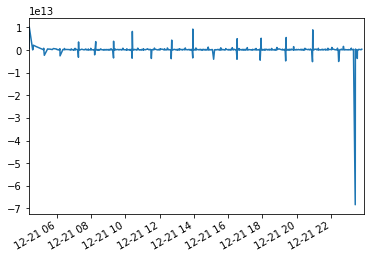

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt

time_till_next_obs.plot()

In [127]:
next_scheduled_arrival_df['R16N']

2018-12-21 04:21:07-05:00    2018-12-21 09:22:08+00:00
2018-12-21 04:21:22-05:00    2018-12-21 09:22:20+00:00
2018-12-21 04:21:37-05:00    2018-12-21 09:22:32+00:00
2018-12-21 04:21:52-05:00    2018-12-21 09:22:44+00:00
2018-12-21 04:22:07-05:00    2018-12-21 09:22:56+00:00
                                       ...            
2018-12-21 23:46:50-05:00    2018-12-22 04:47:32+00:00
2018-12-21 23:51:50-05:00    2018-12-22 04:52:58+00:00
2018-12-21 23:52:20-05:00    2018-12-22 04:52:58+00:00
2018-12-21 23:53:05-05:00    2018-12-22 04:53:44+00:00
2018-12-21 23:53:35-05:00    2018-12-22 04:54:08+00:00
Name: R16N, Length: 2048, dtype: object

In [128]:
time_till_next_scheduled = next_scheduled_arrival_df.shift(-1) - next_scheduled_arrival_df

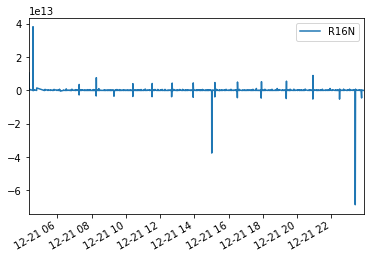

In [135]:
time_till_next_scheduled.plot()

In [79]:
next_train_df['R16N']

2018-12-21 09:21:07    1N 0321 STL/DIT
2018-12-21 09:21:22    1N 0321 STL/DIT
2018-12-21 09:21:37    1N 0321 STL/DIT
2018-12-21 09:21:52    1N 0321 STL/DIT
2018-12-21 09:22:07    1N 0321 STL/DIT
2018-12-21 09:22:22    1N 0321 STL/DIT
2018-12-21 09:22:37    1N 0321 STL/DIT
2018-12-21 09:22:52    1N 0321 STL/DIT
2018-12-21 09:23:07    1N 0321 STL/DIT
2018-12-21 09:33:52    1Q 0410 PAC/962
2018-12-21 09:34:07    1Q 0410 PAC/962
2018-12-21 09:34:22    1Q 0410 PAC/962
2018-12-21 09:34:37    1Q 0410 PAC/962
2018-12-21 09:34:52    1Q 0410 PAC/962
2018-12-21 09:35:22    1Q 0410 PAC/962
2018-12-21 09:35:37    1Q 0410 PAC/962
2018-12-21 09:35:52    1Q 0410 PAC/962
2018-12-21 09:36:07    1Q 0410 PAC/962
2018-12-21 09:36:22    1N 0341 STL/DIT
2018-12-21 09:36:37    1N 0341 STL/DIT
2018-12-21 09:36:52    1N 0341 STL/DIT
2018-12-21 09:37:07    1N 0341 STL/DIT
2018-12-21 09:37:22    1N 0341 STL/DIT
2018-12-21 09:37:37    1N 0341 STL/DIT
2018-12-21 09:37:52    1N 0341 STL/DIT
2018-12-21 09:46:22    1Q